In [1]:
# I installed nucleotide-transformer using: 
# pip install git+https://github.com/instadeepai/nucleotide-transformer@main

# Another method to use nucleotide-transformer: 
# https://huggingface.co/InstaDeepAI/nucleotide-transformer-500m-human-ref?text=ACCTGA%3Cmask%3EAACTGAGTC

import nucleotide_transformer

In [2]:
import haiku as hk
import jax
import jax.numpy as jnp
from nucleotide_transformer.pretrained import get_pretrained_model

In [3]:
model_name = '500M_human_ref'

In [4]:
# Get pretrained model
parameters, forward_fn, tokenizer, config = get_pretrained_model(
    model_name=model_name,
    mixed_precision=False,
    embeddings_layers_to_save=(20,),
    attention_maps_to_save=((1, 4), (7, 18)),
    max_positions=32,
)
forward_fn = hk.transform(forward_fn)

/uufs/chpc.utah.edu/common/HIPAA/u6018199/.cache/nucleotide_transformer/500M_hu
/uufs/chpc.utah.edu/common/HIPAA/u6018199/.cache/nucleotide_transformer/500M_hu


In [5]:
# Get data and tokenize it
sequences = [
    "ATTCCGAAATCGCTGACCGATCGTACGAAA",
    "ATTTCTCTCTCTCTCTGAGATCGATCGATCGATATCTCTCGAGCTAGC",
]
tokens_ids = [b[1] for b in tokenizer.batch_tokenize(sequences)]
tokens_str = [b[0] for b in tokenizer.batch_tokenize(sequences)]
tokens = jnp.asarray(tokens_ids, dtype=jnp.int32)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [6]:
%%time
# Initialize random key
random_key = jax.random.PRNGKey(0)

# Infer
outs = forward_fn.apply(parameters, random_key, tokens)

CPU times: user 6.64 s, sys: 7.78 s, total: 14.4 s
Wall time: 2.44 s


In [7]:
print(outs.keys())

dict_keys(['attention_map_layer_1_number_4', 'attention_map_layer_7_number_18', 'embeddings_20', 'logits'])


In [8]:
print(outs["embeddings_20"].shape)

(2, 32, 1280)


In [9]:
embeddings = outs["embeddings_20"][:, 1:, :]  # removing CLS token
padding_mask = jnp.expand_dims(tokens[:, 1:] != tokenizer.pad_token_id, axis=-1)
masked_embeddings = embeddings * padding_mask  # multiply by 0 pad tokens embeddings
sequences_lengths = jnp.sum(padding_mask, axis=1)
mean_embeddings = jnp.sum(masked_embeddings, axis=1) / sequences_lengths

In [10]:
print(mean_embeddings.shape)

(2, 1280)


In [11]:
print(outs["attention_map_layer_1_number_4"].shape)

(2, 32, 32)


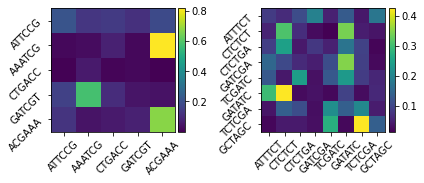

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# plot attention maps
fig, axes = plt.subplots(nrows=1, ncols=2)

seq_length0, seq_length1 = int(sequences_lengths[0]), int(sequences_lengths[1])

# plot for first seq in the batch
im0 = axes[0].imshow(
    outs["attention_map_layer_1_number_4"][
        0, 1 : (seq_length0 + 1), 1 : (seq_length0 + 1)
    ]
)
divider0 = make_axes_locatable(axes[0])
cax0 = divider0.append_axes("right", size="5%", pad=0.05)
tokens0 = tokens_str[0][1 : (seq_length0 + 1)]
axes[0].set_xticks(list(range(seq_length0)))
axes[0].set_xticklabels(tokens0, rotation=45)
axes[0].set_yticks(list(range(seq_length0)))
axes[0].set_yticklabels(tokens0, rotation=45)
fig.colorbar(im0, cax=cax0, orientation="vertical")

# plot for second seq in the batch
im1 = axes[1].imshow(
    outs["attention_map_layer_1_number_4"][
        1, 1 : (seq_length1 + 1), 1 : (seq_length1 + 1)
    ]
)
divider1 = make_axes_locatable(axes[1])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
tokens1 = tokens_str[1][1 : (seq_length1 + 1)]
axes[1].set_xticks(list(range(seq_length1)))
axes[1].set_xticklabels(tokens1, rotation=45)
axes[1].set_yticks(list(range(seq_length1)))
axes[1].set_yticklabels(tokens1, rotation=45)
fig.colorbar(im1, cax=cax1, orientation="vertical")

fig.tight_layout()

In [22]:
logits = outs["logits"]
probabilities = []

# get probabilities separately for each seq as they have different lengths
for seq_id in range(logits.shape[0]):

    logits_seq = logits[seq_id]
    seq_length = int(sequences_lengths[seq_id])
    logits_seq = logits_seq[1 : (seq_length + 1)]  # remove CLS token and pads
    probas = jax.nn.softmax(
        logits_seq, axis=-1
    )  # use softmax to transform logits into probabilities

    print(probas.shape)
    probabilities.append(probas)

(5, 4105)
(8, 4105)


In [23]:
sequence_id = 0
position_id = 1

probs = probabilities[sequence_id][position_id]
sorted_positions = jnp.argsort(-probs)
sorted_probs = probs[sorted_positions]

top_k = 5
for k in range(top_k):
    predicted_token = tokenizer.id_to_token(int(sorted_positions[k]))
    prob = sorted_probs[k]
    print(f"token: {predicted_token}, probability: {prob * 100:.2f}%")

token: CTTCCT, probability: 26.59%
token: CTTTCT, probability: 9.63%
token: TTTCCT, probability: 4.15%
token: CTTCTC, probability: 3.31%
token: CTTTTC, probability: 2.59%
